# System Identification - NARX

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, with the parameter $\tau$ representing the precision of the process. Measurement noise is also Wiener, with $\gamma$ as precision.

### Forecasting experiment

In this notebook, we will perform a forecasting experiment. The time-series will be split into a training and a validation part. In the training part, we will provide both input and output, and then infer parameters. In the forecasting part, we will only provide input. The parameters will be fixed to their inferred values and we will let the model make predictions for the output. Those predictions are evaluated against the true output.

### Data

Let's first have a look at the data.

In [1]:
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Select training set
ix_trn = Array{Int64,1}(4.05*1e4:131072)
input_trn = input[ix_trn]
output_trn = output[ix_trn]
T_trn = length(ix_trn);

# Select validation set
ix_val = Array{Int64,1}(1e3:(4.05*1e4-1))
input_val = input[ix_val]
output_val = output[ix_val]
T_val = length(ix_val);

In [5]:
# Plot every n-th time-point to avoid figure size exploding
n = 50

if viz
    p1a = plot(1:n:T_trn, input_trn[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
    p1b = plot(1:n:T_trn, output_trn[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1, "viz/training_set.png")
end

In [6]:
if viz
    p2a = plot(1:n:T_val, input_val[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="validation")    
    p2b = plot(1:n:T_val, output_val[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p2 = plot(p2a, p2b, layout=(2,1))
#     Plots.savefig(p2, "viz/validation_set.png")
end

## Solution steps

In this notebook we are tackling the system with a black-box model, ignoring the physical parameters altogether.

### 1. NARX model

NARX stands for Nonlinear AutoRegressive model with eXogenous input. It sports the following output function:

$$\begin{align}
y_t =&\ f(\theta, x_{t-1}, u_t, z_{t-1})  + e_t
\end{align}$$

where $x_{t-1} = [y_{t-1}, \dots, y_{t-M}]^{\top}$ is the vector containing the history of $M$ previous observations and $z_{t-1} = [u_{t-1}, \dots, u_{t-N}]^{\top}$ is the history of $N$ previous inputs.

### 2. Convert to Gaussian probability

Integrating out $e_t$ produces a Gaussian state transition node:

$$y_t \sim \mathcal{N}(f(\theta, x_{t-1}, u_t, z_{t-1}), \gamma^{-1}) \, .$$

We can approximate the nonlinearity $f$ around $\theta$ through a Taylor series:

$$f(\theta, x_{t-1}, u_t, z_{t-1}) \approx f(m_\theta, x_{t-1}, u_t, z_{t-1}) + J_{\theta}^{\top}(\theta - m_{\theta})$$

where $J_{\theta} = \frac{d f}{d \theta} \big\vert_{\theta = m_{\theta}}$. The Jacobian can be obtained automatically using Julia packages such as [Zygote.jl](https://github.com/FluxML/Zygote.jl). 

The above is a likelihood node. The state transitions are deterministic and consist of just updating the history vectors $x_t = S_{M}x_{t-1} + s_{M}y_t$ and $z_t = S_{N}z_{t-1} + s_{N}u_t$, where:

$$ S_{M} = \begin{bmatrix} 0 \dots & 0 \\ I_{M-1} & 0 \end{bmatrix} \, , \quad s_{M} = \begin{bmatrix} 1 & 0_1 & \dots & 0_{M-1}\end{bmatrix}^{\top}$$

and likewise for $S_N$.

### 3. Choose priors

We currently have unknown parameters $\theta$ and $\gamma$. The coeffients can be both positive and negative, so we will opt for a Gaussian prior. The prior for a precision parameter $\gamma$ will be a Gamma distribution.

$$\begin{align}
p(\theta) =&\ \text{Normal}(\theta \mid m^{0}_{\theta}, V^{0}_{\theta}) \\
p(\gamma) =&\ \text{Gamma}(\gamma \mid a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Given the Taylor approximation, both priors are conjugate to the Gaussian likelihood node.

### 4. Recognition model

We choose the simplest possible recognition model, a mean-field factorisation of both unknown variables:

$$\begin{align}
q(\theta) =&\ \text{Normal}(\theta \mid m_{\theta}, V_{\theta}) \\
q(\gamma) =&\ \text{Gamma}(\gamma \mid a_\gamma, b_\gamma) 
\end{align}$$

Note that the generative and recognition model match, which means the recognition model's approximation error is potentially $0$.

## Implementation

We implement this model with the toolbox ForneyLab.jl and a custom NARX node.

In [7]:
using ProgressMeter
using LinearAlgebra
using ForneyLab

import MultivariatePolynomials: monomials, subs
import TypedPolynomials: @polyvar
import ForneyLab: unsafeMean

In [8]:
using NARX

┌ Info: Precompiling NARX [5b94cb4d-efdf-4741-8797-809727ab3669]
└ @ Base loading.jl:1278


In [9]:
# Start graph
graph = FactorGraph()

# Autoregression orders
n_x = 2
n_z = 2
n_k = n_x + 1 + n_z

# Basis expansion
n_d = 3;
@polyvar ξ[1:5]
ϕ(x::Array{Float64,1}) = subs(monomials(ξ, 0:n_d), ξ => x)

# Number of parameters
num_coeffs = sum([binomial(d+n_k-1,d) for d=0:3])

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(num_coeffs,)), 
                              placeholder(:W_θ, dims=(num_coeffs, num_coeffs)))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Setup observation and input vectors
@RV x_kmin1
@RV z_kmin1
@RV u_k

# NARX node
@RV y_k ~ NAutoregressiveX(θ, x_kmin1, u_k, z_kmin1, τ, g=ϕ)

# Mark placeholders for observation
placeholder(y_k, :y_k)
placeholder(u_k, :u_k)
placeholder(x_kmin1, :x_kmin1, dims=(n_x,))
placeholder(z_kmin1, :z_kmin1, dims=(n_z,))

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15372007839745317795 -->
 
 15372007839745317795 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 7141529041598780958 -->
 
 7141529041598780958 
 
 placeholder_m_θ 
 
<!-- 15372007839745317795--7141529041598780958 -->
 
 15372007839745317795--7141529041598780958 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 18200438389976979839 -->
 
 18200438389976979839 
 
 placeholder_W_θ 
 
<!-- 15372007839745317795--18200438389976979839 -->
 
 15372007839745317795--18200438389976979839 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 1791816181478400762 -->
 
 1791816181478400762 
 
 placeholder_x_kmin1 
 
<!-- 9422881546349917408 -->
 
 9422881546349917408 
 
 NARX 
 nautoregressivex_1 
 
<!-- 1791816181478400762--9422881546349917408 -->
 
 1791816181478400762--9422881546349917408 
 
 x_kmin1 
 3 x 
 1 out 
 
<!-- 791356480586273138 -->
 
 791356480586273138 
 
 placeholder_z_kmin1 
 
<!-- 791356480586273138--9422881546349917408 -->
 
 791356480586273138--9422881546349917408 
 
 z_kmin1 
 5 z 
 1 out 
 
<!-- 5316485329419027258 -->
 
 5316485329419027258 
 
 placeholder_b_τ 
 
<!-- 1214326060535036737 -->
 
 1214326060535036737 
 
 placeholder_y_k 
 
<!-- 1214326060535036737--9422881546349917408 -->
 
 1214326060535036737--9422881546349917408 
 
 y_k 
 1 y 
 1 out 
 
<!-- 677163566132758805 -->
 
 677163566132758805 
 
 Gam 
 gamma_1 
 
<!-- 677163566132758805--5316485329419027258 -->
 
 677163566132758805--5316485329419027258 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 13339367073221863729 -->
 
 13339367073221863729 
 
 placeholder_a_τ 
 
<!-- 677163566132758805--13339367073221863729 -->
 
 677163566132758805--13339367073221863729 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 6137169518966050542 -->
 
 6137169518966050542 
 
 placeholder_u_k 
 
<!-- 6137169518966050542--9422881546349917408 -->
 
 6137169518966050542--9422881546349917408 
 
 u_k 
 4 u 
 1 out 
 
<!-- 9422881546349917408--15372007839745317795 -->
 
 9422881546349917408--15372007839745317795 
 
 θ 
 1 out 
 2 θ 
 
<!-- 9422881546349917408--677163566132758805 -->
 
 9422881546349917408--677163566132758805 
 
 τ 
 1 out 
 6 τ

In [10]:
# Define variational message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])
algo = messagePassingAlgorithm(free_energy=false)

# Compile and import compiled functions
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

### Infer parameters

In [11]:
# Inference parameters
num_iterations = 5

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_θ = (ones(num_coeffs, T_trn+1), repeat(.1 .*float(eye(num_coeffs)), outer=(1,1, T_trn+1)))
params_τ = (1. *ones(1, T_trn+1), 1. *ones(1, T_trn+1))

# Filtering
@showprogress for t = max(n_x, n_z)+1:T_trn

    # Initialize marginals
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,t], b=params_τ[2][1,t])

    # Update observed data
    data = Dict(:y_k => output[t],
                :x_kmin1 => output[t-1:-1:t-n_x],
                :u_k => input[t],
                :z_kmin1 => input[t-1:-1:t-n_z],
                :m_θ => params_θ[1][:,t],
                :W_θ => params_θ[2][:,:,t],
                :a_τ => params_τ[1][1,t],
                :b_τ => params_τ[2][1,t])

    for i = 1:num_iterations
        
        # Update precision
        stepτ!(data, marginals)

        # Update coefficients
        stepθ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_τ[1][1,t+1] = marginals[:τ].params[:a]
    params_τ[2][1,t+1] = marginals[:τ].params[:b]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:54:53


In [12]:
using JLD
save("FEM-NARXpol3.jld", "params_θ", "params_τ")

## 1-step ahead prediction error

In [13]:
# Start graph
graph2 = FactorGraph()

# Clamped variables
@RV x_kmin1
@RV z_kmin1
@RV u_k
@RV θ
@RV τ

# Autoregressive node
@RV y_k ~ NAutoregressiveX(θ, x_kmin1, u_k, z_kmin1, τ, g=ϕ)

# Indicate observed variables
placeholder(θ, :θ, dims=(n_x + n_z + 1,))
placeholder(x_kmin1, :x_kmin1, dims=(n_x,))
placeholder(z_kmin1, :z_kmin1, dims=(n_z,))
placeholder(u_k, :u_k)
placeholder(τ, :τ)

# Draw time-slice subgraph
# ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(y_k, ids=[:y_k])
algo2 = messagePassingAlgorithm(y_k, q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code2)

In [14]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mτ = params_τ[1][1,end]/params_τ[2][1,end]

# Initialize arrays of parameterizations
params_y = (zeros(1,T_val), zeros(1,T_val))

# Perform inference at each time-step
@showprogress for t = max(n_x, n_z)+1:T_val

    # Initialize marginals
    marginals[:y_k] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_y[1][:,t-1], w=params_y[2][1,t-1])
    
    # Set clamped variables
    data = Dict(:u_k => input_val[t],
                :x_kmin1 => output_val[t-1:-1:t-n_x],
                :z_kmin1 => input_val[t-1:-1:t-n_z],
                :θ => mθ,
                :τ => mτ)
        
    # Update output prediction
    stepy_k!(data, marginals)

    # Store current parameterizations of marginals
    params_y[1][1,t] = unsafeMean(marginals[:y_k])
    params_y[2][1,t] = marginals[:y_k].params[:w]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


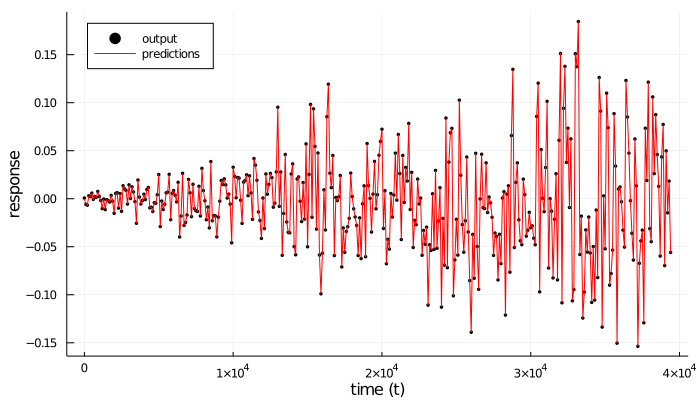

In [15]:
# Plot every n-th time-point to avoid figure size exploding
n = 100

# Extract mean of state marginals
predictions = params_y[1][1,:]

p3 = scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

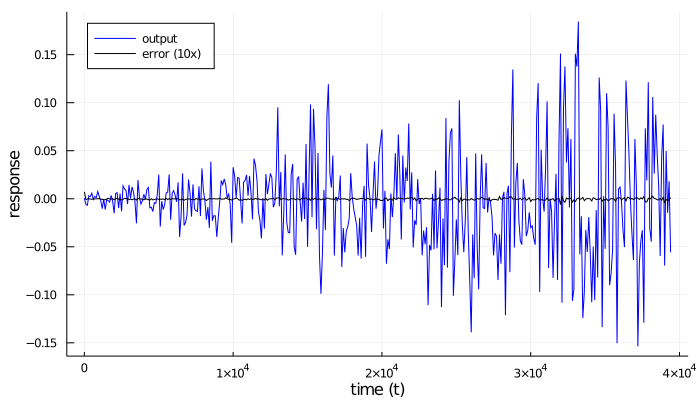

In [16]:
# Extract mean of state marginals
predictions = params_y[1][1,:]
error = output_val .- predictions

p3 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, 10 .*error[1:n:T_val], color="black", linewidth=1, label="error (10x)", size=(700,400))

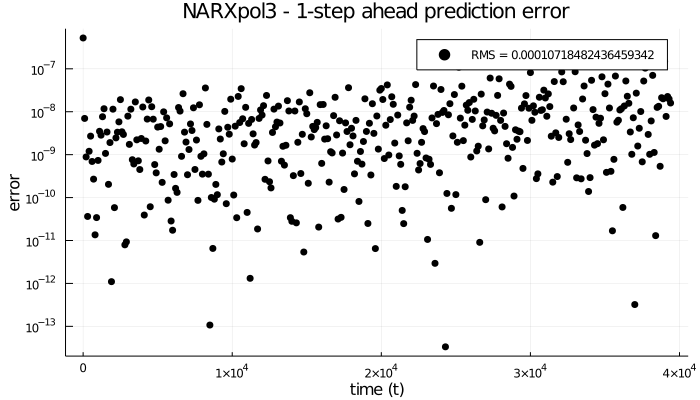

In [17]:
# Error plot
sq_pred_error_FEM = (output_val .- predictions).^2
p4 = scatter(1:n:T_val, 
             sq_pred_error_FEM[1:n:T_val], 
             color="black", 
             markersize=4, 
             size=(700,400), 
             xlabel="time (t)", 
             ylabel="error",
             labels="RMS = "*string(sqrt(mean(sq_pred_error_FEM))),
             yscale=:log10,
             title="NARXpol3 - 1-step ahead prediction error")

In [18]:
savefig(p4, "figures/FEM_NARXpol3_pred-errors.png")

## Simulation error on validation data

In [19]:
# Start graph
graph2 = FactorGraph()

# Clamped variables
@RV x_kmin1
@RV z_kmin1
@RV u_k
@RV θ
@RV τ

# Autoregressive node
@RV y_k ~ NAutoregressiveX(θ, x_kmin1, u_k, z_kmin1, τ, g=ϕ)

# Indicate observed variables
placeholder(θ, :θ, dims=(n_x + 1 + n_z,))
placeholder(x_kmin1, :x_kmin1, dims=(n_x,))
placeholder(z_kmin1, :z_kmin1, dims=(n_z,))
placeholder(u_k, :u_k)
placeholder(τ, :τ)

# Draw time-slice subgraph
# ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(y_k, ids=[:y_k])
algo2 = messagePassingAlgorithm(y_k, q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code2)

In [20]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mτ = params_τ[1][1,end]/params_τ[2][1,end]

# Initialize arrays of parameterizations
params_y = (zeros(1,T_val), zeros(1,T_val))

# Perform inference at each time-step
@showprogress for t = max(n_x, n_z)+1:T_val

    # Initialize marginals
    marginals[:y_k] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_y[1][:,t-1], w=params_y[2][1,t-1])
    
    # Set clamped variables
    data = Dict(:u_k => input_val[t],
                :x_kmin1 => params_y[1][1,t-1:-1:t-n_x],
                :z_kmin1 => input_val[t-1:-1:t-n_z],
                :θ => mθ,
                :τ => mτ)
        
    # Update output prediction
    stepy_k!(data, marginals)

    # Store current parameterizations of marginals
    params_y[1][1,t] = unsafeMean(marginals[:y_k])
    params_y[2][1,t] = marginals[:y_k].params[:w]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


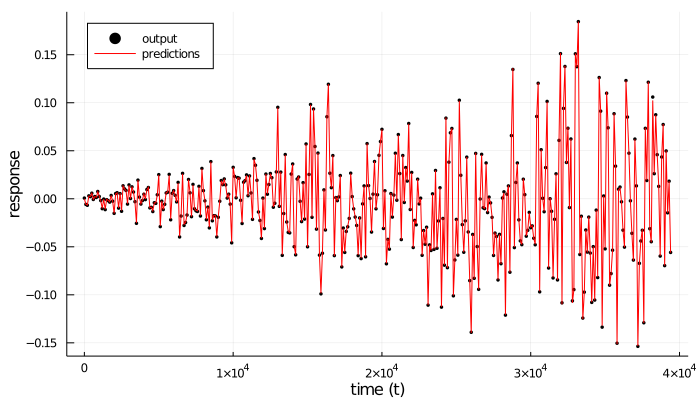

In [21]:
# Extract mean of state marginals
predictions = params_y[1][1,:]

p3 = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

In [22]:
savefig(p3, "figures/FEM_NARXpol3_sim-forecasts.png")

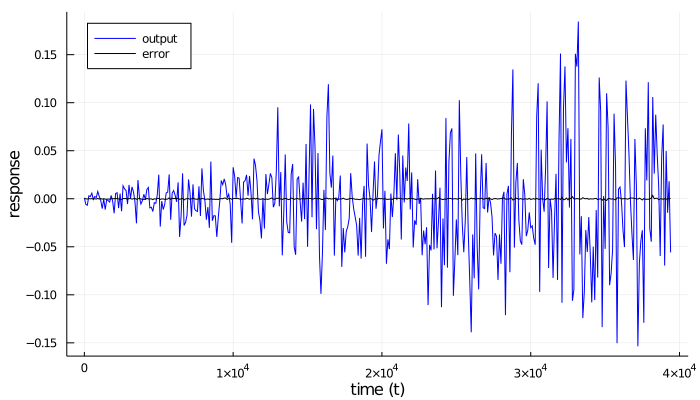

In [23]:
# Extract mean of state marginals
predictions = params_y[1][1,:]
error = output_val .- predictions

p12 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, error[1:n:T_val], color="black", linewidth=1, label="error", size=(700,400))

In [24]:
savefig(p12, "figures/FEM_NARXpol3_sim-forecasts.png")

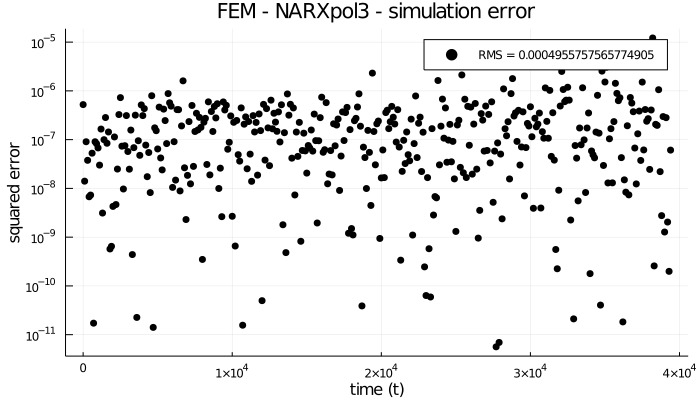

In [25]:
# Error plot
sq_sim_error_FEM = (predictions .- output_val).^2
p3b = scatter(1:n:T_val, 
              sq_sim_error_FEM[1:n:T_val], 
              color="black", 
              markersize=4, 
              size=(700,400), 
              xlabel="time (t)", 
              ylabel="squared error",
              labels="RMS = "*string(sqrt(mean(sq_sim_error_FEM))),
              yscale=:log10,
              title="FEM - NARXpol3 - simulation error")

In [26]:
savefig(p3b, "figures/FEM_NARXpol3_sim-error.png")

### Baseline: NARXpol3-PEM

Maarten Schoukens has implemented a NARX model using least squares minimization for a polynomial basis expansion of order 3.

In [27]:
using MAT
results = matread("../sota-baselines/NARXpol3-PEM.mat");

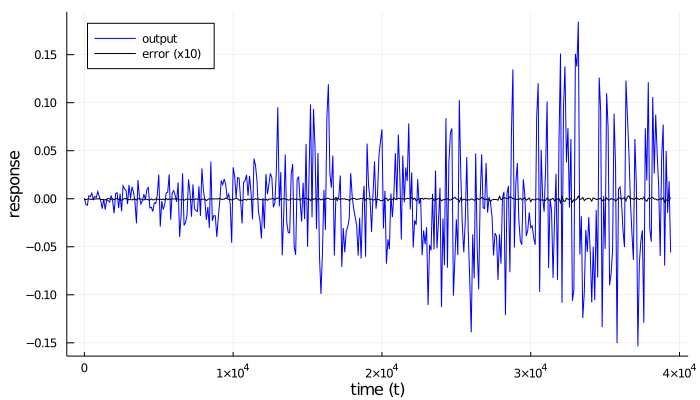

In [28]:
# Extract mean of state marginals
error = output[ix_val] .- results["yPred"][ix_val]

p14 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, 10 .*error[1:n:T_val], color="black", linewidth=1, label="error (x10)", size=(700,400))

In [29]:
savefig(p14, "figures/PEM_NARXpol3_pred-forecasts.png")

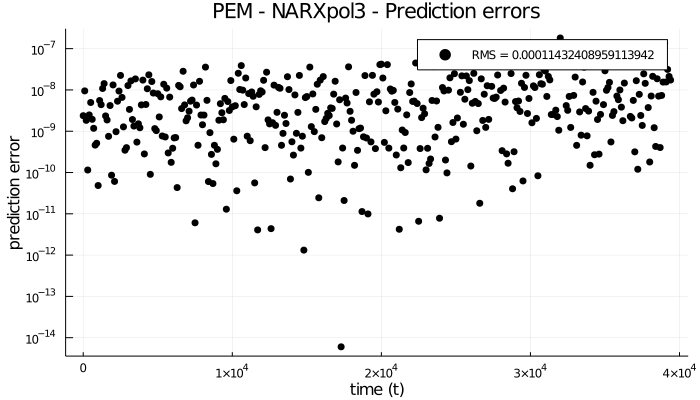

In [30]:
# Error plot
sq_pred_error_PEM = (output[ix_val] .- results["yPred"][ix_val]).^2
p15 = scatter(1:n:T_val, 
              sq_pred_error_PEM[1:n:T_val], 
              color="black", 
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="prediction error",
              labels="RMS = "*string(sqrt(mean(sq_pred_error_PEM))),
              title="PEM - NARXpol3 - Prediction errors")

In [31]:
savefig(p15, "figures/PEM_NARXpol3_pred-error.png")

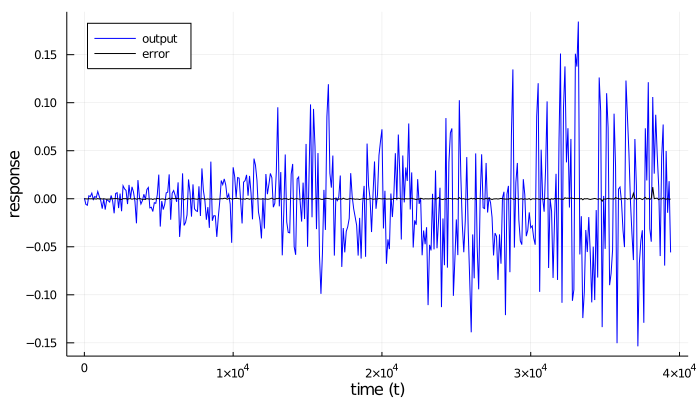

In [32]:
error = output[ix_val] .- results["ySim"][ix_val]

p16 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", label="output", xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, error[1:n:T_val], color="black", linewidth=1, label="error", size=(700,400))

In [33]:
savefig(p16, "figures/PEM_NARXpol3_sim-forecasts.png")

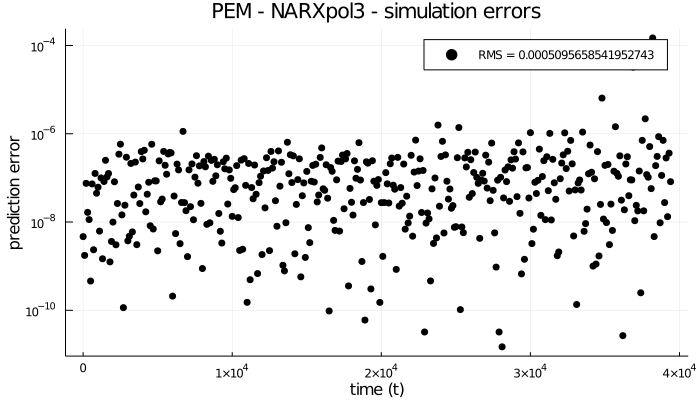

In [34]:
# Error plot
sq_sim_error_PEM = (output[ix_val] .- results["ySim"][ix_val]).^2
p17 = scatter(1:n:T_val, 
              sq_sim_error_PEM[1:n:T_val], 
              color="black", 
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="prediction error",
              labels="RMS = "*string(sqrt(mean(sq_sim_error_PEM[3:n:T_val]))),
              title="PEM - NARXpol3 - simulation errors")

In [35]:
savefig(p17, "figures/PEM_NARXpol3_sim-error.png")

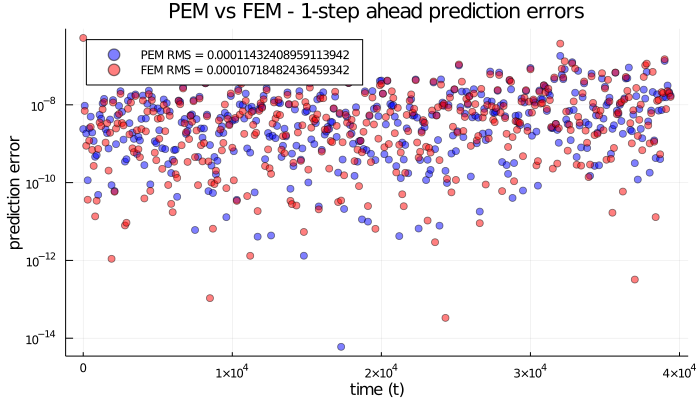

In [36]:
# Comparing 1-step ahead prediction errors between PEM and FEM
p18 = scatter(1:n:T_val, 
              sq_pred_error_PEM[1:n:T_val], 
              color="blue", 
              alpha=0.5,
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="prediction error",
              label="PEM RMS = "*string(sqrt(mean(sq_pred_error_PEM))),
              legend=:topleft)
scatter!(1:n:T_val, 
         sq_pred_error_FEM[1:n:T_val], 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(sqrt(mean(sq_pred_error_FEM))),
         title="PEM vs FEM - 1-step ahead prediction errors")

In [37]:
savefig(p18, "figures/PEMvFEM_NARXpol3_pred-error.png")

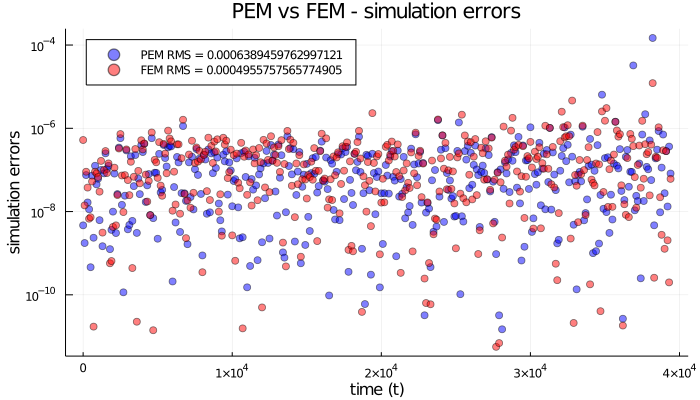

In [38]:
# Comparing simulation errors between PEM and FEM
p19 = scatter(1:n:T_val, 
              sq_sim_error_PEM[1:n:T_val], 
              color="blue", 
              alpha=0.5,
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="simulation errors",
              label="PEM RMS = "*string(sqrt(mean(sq_sim_error_PEM))),
              legend=:topleft)
scatter!(1:n:T_val, 
         sq_sim_error_FEM[1:n:T_val], 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(sqrt(mean(sq_sim_error_FEM))),
         title="PEM vs FEM - simulation errors")

In [39]:
savefig(p19, "figures/PEMvFEM_NARXpol3_sim-error.png")